# Figure 1. SUPP Model fixation dynamics compared to Yogyakarta RCT

In [1]:
from scipy.integrate import odeint #differential model
import numpy as np #functionality
import matplotlib.pyplot as plt #plotting
import pandas as pd #database wrangling

### 1. Run model with nine Wolbachia releases

Parameters:

In [2]:
# MOSQUITO
alphaO=0.5  # rate that eggs hatch into larvae
alphaL=0.18  # rate that larvae pupate
alphaP=1  # rate that pupae eclose
phi=500*(1/14)    # number eggs laid per mosquito per day
muO=0.01    # daily death rate of eggs
muL=0.1*alphaL    # daily death rate of larvae
muP=0.1*alphaP     # pupae death rate
muM=1/14     # adult mosquito death rate
muF=1/14     # adult female mosquito death rate

# density-dependence via Bellows 1981:
AA=1   # determines the density at which mortality remains proportionate
BB=0.5   # determines the 'abruptness' of density-dependence

# WOLBACHIA
fCI=0.012   # prop of cytoplasmic incompatibility that fails 'sigma'
MT=0 #0.11    # prop of wolbachia females that don't successfully maternally transfer 'omega'
c=0.5      # mating competitiveness of released wolbachia males
e=1.2      # relative mortality of wolbachia adults compared to wild adults
RR=0.0775 #0.2953      # release ratio of wolbachia eggs to wild type eggs

Initial conditions:

In [3]:
O0=15947.608023052446
OW0=0
rOW0=0
L0=40271.71074193975
LW0=0
rLW0=0
P0=32.67541200187585
PW0=0
rPW0=0
M0=228.72754035145144
MW0=0
F0=228.72754035145144
FW0=0

Wolbachia release function:

In [4]:
fN = 14                        #frequency of new Wol release
start_N = 139                   #day to first deploy Wol 
stop_N = 253 #330                   #stop deploying wolbachia - 253 is 9 330 is 14

def pulseN(t):
    if round(t) < start_N:     #start releases
        return 0
    elif round(t) % fN > 0:    #do it every fN days i.e. if modulus is anything but zero do nothing
        return 0
    elif round(t) > stop_N:    #stop releases
        return 0
    else:
        return O0 #15947.608023052446 #equilibrium

Wolbachia model:

In [5]:
def deriv(y, t, fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, pulseN):
    
    O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = y
    
    #MOSQUITOES
    
    allmales = 1+M+MW
    
    F_nothing = F + FW*MT 
    M_nothing = M + MW*fCI 
    
    F_wol = FW*(1-MT)
    
    #Eggs
    dOdt = phi * F_nothing * M_nothing/allmales - alphaO*O - muO*O
    # eggs laid * females no-wol * (males no_wol / all males) (aka prop no-wol males)
    dOWdt = phi * F_wol - alphaO*OW - muO*OW 
    drOWdt = pulseN(t)*RR - alphaO*rOW - muO*rOW 
        
    #Larvae
    dLdt =  alphaO*O - alphaL*L - muL*L 
    dLWdt = alphaO*OW - alphaL*LW - muL*LW
    drLWdt = alphaO*rOW - alphaL*rLW - muL*rLW
    
    #Pupae
    dPdt =  alphaL*(L/(1+((AA*(L+LW))**BB))) - alphaP*P - muP*P 
    dPWdt = alphaL*(LW/(1+((AA*(L+LW))**BB))) - alphaP*PW - muP*PW
    drPWdt = alphaL*(rLW/(1+((AA*(rLW))**BB))) - alphaP*rPW - muP*rPW 
    
    #Adult
    dMdt =  0.5*alphaP*P - muM*M
    dMWdt = 0.5*alphaP*(PW+rPW) - muM*MW*e
    
    dFdt = 0.5*alphaP*P - muF*F
    dFWdt = 0.5*alphaP*(PW+rPW) - muF*FW*e  

    return dOdt, dOWdt, drOWdt, dLdt, dLWdt, drLWdt, dPdt, dPWdt, drPWdt,  dMdt, dMWdt, dFdt, dFWdt

Run model:

In [6]:
t = np.linspace(0, 1500, 1501) # grid of time points (in days)
y0 = O0, OW0, rOW0, L0, LW0, rLW0, P0, PW0, rPW0, M0, MW0, F0, FW0 # initial condition vector

# integrate the SIR equations over the time grid, t
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA,BB, alphaL, alphaP, muP, muM, muF, RR, pulseN),hmax=1)

O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = ret.T

Visual check population dynamics look reasonable:

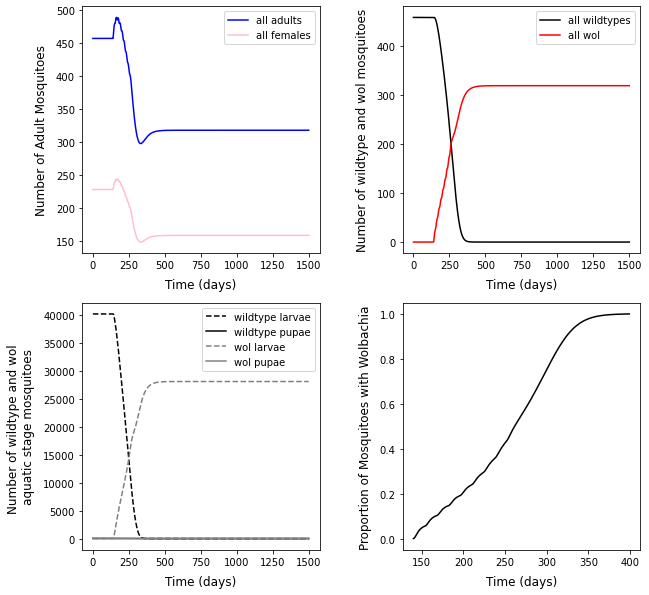

In [7]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10,10])

ax1.plot(t, F+FW+M+MW, 'blue', label='all adults')
ax1.plot(t, F+FW, 'pink', label='all females')
ax1.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax1.set_ylabel("Number of Adult Mosquitoes",fontsize=12, labelpad=8)
ax1.legend()

ax2.plot(t, M+F, 'black', label='all wildtypes')
ax2.plot(t, MW+FW, 'red', label='all wol')
ax2.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax2.set_ylabel("Number of wildtype and wol mosquitoes",fontsize=12, labelpad=8)
ax2.legend()

ax3.plot(t, L, 'black', linestyle='dashed', label='wildtype larvae')
ax3.plot(t, P, 'black', label='wildtype pupae')
ax3.plot(t, LW, 'grey', linestyle='dashed', label='wol larvae')
ax3.plot(t, PW, 'grey', label='wol pupae')
ax3.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax3.set_ylabel("Number of wildtype and wol \naquatic stage mosquitoes",fontsize=12, labelpad=8)
ax3.legend()

ax4.plot(t[140:400], (MW[140:400]+FW[140:400])/(MW[140:400]+FW[140:400]+M[140:400]+F[140:400]), 'black')
plt.xticks([150,200,250,300,350,400])
ax4.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax4.set_ylabel("Proportion of Mosquitoes with Wolbachia",fontsize=12, labelpad=8)


plt.subplots_adjust(wspace=.35)

#plt.savefig('wolAedesDemo-KT', dpi=300, facecolor='w', edgecolor='w',
#        orientation='portrait', format=None, transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

Store results:

In [80]:
total_r9 = MW+FW+M+F
totalwol_r9 = MW+FW
propwol_r9 = totalwol_r9/total_r9
propwol100_r9 = propwol_r9*100

### 2. Run model with fourteen Wolbachia releases

Wolbachia release function:

In [81]:
fN = 14                        #frequency of new Wol release
start_N=139                   #day to first deploy Wol 
stop_N= 323                   #stop deploying wolbachia - 253 is 9 330 is 14

def pulseN(t):
    if round(t) < start_N:     #start releases
        return 0
    elif round(t) % fN > 0:    #do it every fN days i.e. if modulus is anything but zero do nothing
        return 0
    elif round(t) > stop_N:    #stop releases
        return 0
    else:
        return O0 #15947.608023052446 #equilibrium

Run model:

In [82]:
t = np.linspace(0, 1500, 1501) # grid of time points (in days)
y0 = O0, OW0, rOW0, L0, LW0, rLW0, P0, PW0, rPW0, M0, MW0, F0, FW0 # initial condition vector

# integrate the SIR equations over the time grid, t
ret= odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA,BB, alphaL, alphaP, muP, muM, muF, RR, pulseN),hmax=1)

O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = ret.T

Store results:

In [83]:
total_r14 = MW+FW+M+F
totalwol_r14 = MW+FW
propwol_r14 = totalwol_r14/total_r14
propwol100_r14 = propwol_r14*100

Visual check Wolbachia proportions look reasonable:

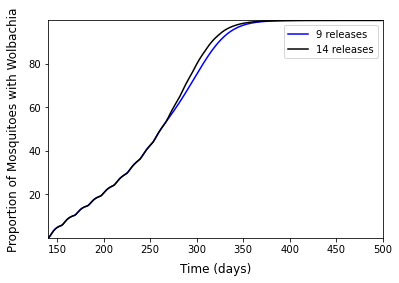

In [84]:
fig, ax4 = plt.subplots()

plt.margins(x=0,y=0)
ax4.plot(t[140:500], propwol100_r9[140:500], 'blue', label="9 releases")
ax4.plot(t[140:500], propwol100_r14[140:500], 'black', label="14 releases")
plt.xticks([150, 200, 250, 300, 350, 400, 450, 500])
ax4.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax4.set_ylabel("Proportion of Mosquitoes with Wolbachia",fontsize=12, labelpad=8)
ax4.legend()
#plt.savefig('wolAedesDemo-KTvline-14r', dpi=300, facecolor='w', edgecolor='w',
#        orientation='portrait', format=None, transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

### 3. Final plot comparing model to field data
Import data:
(extracted from Utarini et al 2021)

In [85]:
dfavg=pd.read_csv("wpd_datasets_avg.csv") # average values

df=pd.read_csv("wpd_datasets_long.csv") # raw values
# format:
set1=df[df.set == 1]
time1=set1['time']
perc1=set1['perc']
set2=df[df.set == 2]
time2=set2['time']
perc2=set2['perc']
set3=df[df.set == 3]
time3=set3['time']
perc3=set3['perc']
set4=df[df.set == 4]
time4=set4['time']
perc4=set4['perc']
set5=df[df.set == 5]
time5=set5['time']
perc5=set5['perc']
set6=df[df.set == 6]
time6=set6['time']
perc6=set6['perc']
set7=df[df.set == 7]
time7=set7['time']
perc7=set7['perc']
set8=df[df.set == 8]
time8=set8['time']
perc8=set8['perc']
set9=df[df.set == 9]
time9=set9['time']
perc9=set9['perc']
set10=df[df.set == 10]
time10=set10['time']
perc10=set10['perc']
set11=df[df.set == 11]
time11=set11['time']
perc11=set11['perc']
set12=df[df.set == 12]
time12=set12['time']
perc12=set12['perc']

Plot results:

Text(0, 0.5, 'Proportion of Mosquitoes with Wolbachia')

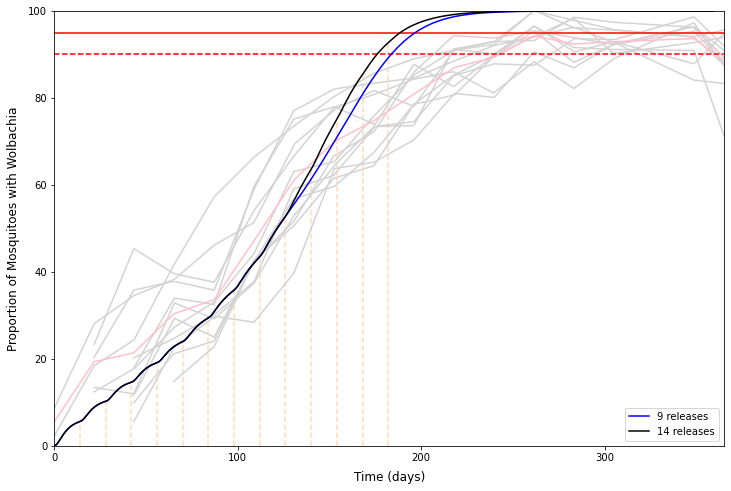

In [86]:
fig, ax4 = plt.subplots(figsize=(12, 8))

plt.margins(x=0,y=0)
plt.axvline(x=140,ymax=propwol_r14[140],color="peachpuff",linestyle="dashed")
plt.axvline(x=154,ymax=propwol_r14[154],color="peachpuff",linestyle="dashed")
plt.axvline(x=168,ymax=propwol_r14[168],color="peachpuff",linestyle="dashed")
plt.axvline(x=182,ymax=propwol_r14[182],color="peachpuff",linestyle="dashed")
plt.axvline(x=196,ymax=propwol_r14[196],color="peachpuff",linestyle="dashed")
plt.axvline(x=210,ymax=propwol_r14[210],color="peachpuff",linestyle="dashed")
plt.axvline(x=224,ymax=propwol_r14[224],color="peachpuff",linestyle="dashed")
plt.axvline(x=238,ymax=propwol_r14[238],color="peachpuff",linestyle="dashed")
plt.axvline(x=252,ymax=propwol_r14[252],color="peachpuff",linestyle="dashed")
plt.axvline(x=266,ymax=propwol_r14[266],color="peachpuff",linestyle="dashed")
plt.axvline(x=280,ymax=propwol_r14[280],color="peachpuff",linestyle="dashed")
plt.axvline(x=294,ymax=propwol_r14[294],color="peachpuff",linestyle="dashed")
plt.axvline(x=308,ymax=propwol_r14[308],color="peachpuff",linestyle="dashed")
plt.axvline(x=322,ymax=propwol_r14[322],color="peachpuff",linestyle="dashed")
ax4.plot(time1,perc1,color="lightgrey")
ax4.plot(time2,perc2,color="lightgrey")
ax4.plot(time3,perc3,color="lightgrey")
ax4.plot(time4,perc4,color="lightgrey")
ax4.plot(time5,perc5,color="lightgrey")
ax4.plot(time6,perc6,color="lightgrey")
ax4.plot(time7,perc7,color="lightgrey")
ax4.plot(time8,perc8,color="lightgrey")
ax4.plot(time9,perc9,color="lightgrey")
ax4.plot(time10,perc10,color="lightgrey")
ax4.plot(time11,perc11,color="lightgrey")
ax4.plot(time12,perc12,color="lightgrey")

ax4.plot(dfavg['X'],dfavg['avg'],color="pink")
plt.axhline(y=90,color="red",linestyle="dashed")
plt.axhline(y=95,color="red",linestyle="solid")
ax4.plot(t[140:500], propwol100_r9[140:500], 'blue', label="9 releases")
ax4.plot(t[140:500], propwol100_r14[140:500], 'black', label="14 releases")
plt.xlim(140,505)
plt.ylim(0,100)
positions = (140, 240, 340, 440)
labels = ("0", "100", "200", "300")
plt.xticks(positions, labels)
plt.yticks([0, 20, 40, 60, 80, 100])
ax4.legend()
ax4.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax4.set_ylabel("Proportion of Mosquitoes with Wolbachia",fontsize=12, labelpad=8)

#plt.savefig('wolAedesDemo-KTvline-9r14r-withyogyakarta-1point2fc-0point1rr', bbox_inches='tight', dpi = 600)